# Exploratory Data Analysis (EDA)
Within the crisp-dm framework this can be seen as `Explore data`

## Overview
This EDA aims to provide a comprehensive first look at the ART500K Toy Dataset, assessing its structure, basic statistics, distributions, relationships, potential data quality issues, and initial implications for downstream modeling. All findings here will inform both the data preparation phase and modeling choices.

## Loading packages
Al packages that are needed in this EDA

In [ ]:
import pandas as pd
import os

import cv2
import sys
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import torch
from torchvision import models, transforms
from sklearn.preprocessing import OneHotEncoder

print("Python:", sys.version)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("opencv-python:", cv2.__version__)
print("umap-learn:", umap.__version__)


Python: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
numpy: 1.26.4
pandas: 2.2.3
scikit-learn: 1.6.1
opencv-python: 4.10.0
umap-learn: 0.5.7


Set the seeds:

In [2]:
SEED=42
np.random.seed(SEED)
umap.UMAP(random_state=SEED)

UMAP(random_state=42)

## Importing data

The full label set of the toy dataset will be loaded into a dataframe. The path to the images is stated for later usage

In [3]:
image_dir = '../data/toy_dataset/'

labels_path = '../data/toy_dataset_label.csv'

df = pd.read_csv(labels_path, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43455 entries, 0 to 43454
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         43455 non-null  int64 
 1   FILE       43454 non-null  object
 2   AUTHOR     43455 non-null  object
 3   BORN-DIED  43455 non-null  object
 4   TITLE      43455 non-null  object
 5   DATE       43455 non-null  object
 6   TECHNIQUE  43455 non-null  object
 7   LOCATION   43455 non-null  object
 8   FORM       43455 non-null  object
 9   TYPE       43455 non-null  object
 10  SCHOOL     43455 non-null  object
 11  TIMELINE   43455 non-null  object
 12  URL        43455 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.3+ MB


In [4]:
df.sample(n=3, random_state=SEED)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL
7462,7463,7463.jpg,"CARPI, Girolamo da","(b. 1501, Ferrara, d. 1556, Ferrara)",Landscape with Magicians,c. 1525,Oil on canvas,"Galleria Borghese, Rome",painting,landscape,Italian,1501-1550,http://www.wga.hu/html/c/carpi/landscap.html
39781,39782,39782.jpg,"UNKNOWN MASTER, French",(active third quarter of 13th century),Prophet,1250-70,Ivory,"Musée du Louvre, Paris",sculpture,religious,French,1251-1300,http://www.wga.hu/html/m/master/yunk_fr/yunk_f...
7231,7232,7232.jpg,"CARIANI, Giovanni","(b. ca. 1485, San Giovanni Bianco, d. ca. 1547...",Reclining Woman in a Landscape,1520-24,"Oil on canvas, 74 x 94 cm","Staatliche Museen, Berlin",painting,landscape,Italian,1501-1550,http://www.wga.hu/html/c/cariani/reclinin.html


In [5]:
df.isnull().sum()

ID           0
FILE         1
AUTHOR       0
BORN-DIED    0
TITLE        0
DATE         0
TECHNIQUE    0
LOCATION     0
FORM         0
TYPE         0
SCHOOL       0
TIMELINE     0
URL          0
dtype: int64

The csv is loaded into the dataframe with the correct count of rows except for the FILE row. This is missing one value.
Due to time constraint this row will be dropped for this iteration

In [6]:
df = df.dropna(subset=['FILE'])

The columns match the stated columns in `/02_describe_data.md`

The image path will be added to the dataframe to easily load images when needed

In [7]:
df['IMAGE_PATH'] = df['FILE'].apply(lambda x: os.path.join(image_dir, x))

missing_images = df[~df['IMAGE_PATH'].apply(os.path.exists)]
print(f"Number of missing image files: {len(missing_images)}")

Number of missing image files: 2


In [8]:
display(missing_images)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL,IMAGE_PATH
19561,19562,19562.jpg,"HUNT, William Holman","(b. 1827, London, d. 1910, London)",The Lady of Shalott (detail),1886-1905,Oil on canvas,"Wadsworth Atheneum, Hartford",painting,other,English,1801-1850,http://www.wga.hu/html/h/hunt/y_lady183c.html,../data/toy_dataset/19562.jpg
21911,21912,21912.jpg,"LISSE, Dirck van der","(b. 1607, Breda, d. 1669, Den Haag)",Landscape with Diana and Actaeon,-,"Oil on panel, 35 x 47 cm",Private collection,painting,landscape,Dutch,1601-1650,http://www.wga.hu/html/l/lisse/lisse_c.html,../data/toy_dataset/21912.jpg


In [9]:
df = df.drop(missing_images.index).reset_index(drop=True)

These two rows do not exist in the toy_dataset folder. After a manual check this is confirmed twice. These two rows will be dropped from the dataframe due to time contraint

## Data completeness and types
In the following code blocks there will be a check on how complete the data is and what is consists of and if the types need to be refined

In [10]:
df.sample(n=5, random_state=SEED)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL,IMAGE_PATH
31795,31798,31798.jpg,RAFFAELLO Sanzio,"(b. 1483, Urbino, d. 1520, Roma)",La Disputa (detail),1510-11,"Fresco, width of detail: 225 cm","Stanza della Segnatura, Palazzi Pontifici, Vat...",painting,religious,Italian,1501-1550,http://www.wga.hu/html/r/raphael/4stanze/1segn...,../data/toy_dataset/31798.jpg
17714,17715,17715.jpg,"GRECO, El","(b. 1541, Candia, d. 1614, Toledo)",The Coronation of the Virgin,1603-05,"Oil on canvas, 163 x 220 cm","Hospital de la Caridad, Illescas",painting,religious,Spanish,1551-1600,http://www.wga.hu/html/g/greco_el/16/1602grec....,../data/toy_dataset/17715.jpg
20788,20790,20790.jpg,"LAWRENCE, Sir Thomas","(b. 1769, Bristol, d. 1830, London)",Portrait of Canova,-,"Oil on canvas, 58 x 49 cm",Private collection,painting,portrait,English,1751-1800,http://www.wga.hu/html/l/lawrence/canova.html,../data/toy_dataset/20790.jpg
15239,15240,15240.jpg,"GIORDANO, Luca","(b. 1634, Napoli, d. 1705, Napoli)",Venus Punishing Psyche with a Task (?),1692-1702,"Oil on copper, 58,1 x 68,9 cm","Royal Collection, Windsor",painting,mythological,Italian,1651-1700,http://www.wga.hu/html/g/giordano/2/psyche4.html,../data/toy_dataset/15240.jpg
16157,16158,16158.jpg,GIULIO ROMANO,"(b. ca. 1499, Roma, d. 1546, Mantova)",Vaulted ceiling (detail),1526-28,Fresco,"Sala di Psiche, Palazzo del Tè, Mantua",painting,mythological,Italian,1501-1550,http://www.wga.hu/html/g/giulio/1pala_te/psych...,../data/toy_dataset/16158.jpg


With this sample there is a good sense of what the data looks like, the column ID clearly shows integers and is not expected to deviate. The FILE, AUTHOR, TITLE are good as string(object) types

now the unique values for the rows will be printed together with a percentage of how unique they are to find categorical types

In [11]:
for col in df.columns:
    unique_count = df[col].nunique()
    total_count = len(df)
    print(f"{col}: {unique_count} unique values ({unique_count/total_count:.2%} of {total_count})")

ID: 43452 unique values (100.00% of 43452)
FILE: 43452 unique values (100.00% of 43452)
AUTHOR: 4991 unique values (11.49% of 43452)
BORN-DIED: 7151 unique values (16.46% of 43452)
TITLE: 27090 unique values (62.34% of 43452)
DATE: 4958 unique values (11.41% of 43452)
TECHNIQUE: 21437 unique values (49.33% of 43452)
LOCATION: 4064 unique values (9.35% of 43452)
FORM: 13 unique values (0.03% of 43452)
TYPE: 10 unique values (0.02% of 43452)
SCHOOL: 26 unique values (0.06% of 43452)
TIMELINE: 24 unique values (0.06% of 43452)
URL: 43452 unique values (100.00% of 43452)
IMAGE_PATH: 43452 unique values (100.00% of 43452)


The columns `FORM`, `TYPE`, `SCHOOL`, `TIMELINE` and `LOCATION` show they do not occur many times in the dataframe and going from the column name itself it would be logical if these are categories

In [12]:
categorical_columns = ['FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'LOCATION']

for col in categorical_columns:
    print(f"Unique values in {col} before cleaning:")
    print(df[col].unique())
    print("\n")

Unique values in FORM before cleaning:
['painting' 'ceramics' 'sculpture' 'graphics' 'architecture'
 'stained-glass' 'metalwork' 'illumination' 'mosaic' 'others' 'furniture'
 'tapestry' 'glassware']


Unique values in TYPE before cleaning:
['mythological' 'genre' 'portrait' 'landscape' 'religious' 'other'
 'historical' 'interior' 'still-life' 'study']


Unique values in SCHOOL before cleaning:
['German' 'Danish' 'Spanish' 'French' 'Italian' 'Dutch' 'Scottish'
 'Flemish' 'Netherlandish' 'Swiss' 'Russian' 'Greek' 'Other' 'American'
 'English' 'Austrian' 'Portuguese' 'Bohemian' 'Catalan' 'Hungarian'
 'Irish' 'Norwegian' 'Polish' 'Swedish' 'Belgian' 'Finnish']


Unique values in TIMELINE before cleaning:
['1601-1650' '1851-1900' '1451-1500' '1501-1550' '1751-1800' '1551-1600'
 '1801-1850' '1701-1750' '1651-1700' '1301-1350' '1401-1450' '1351-1400'
 '1151-1200' '1251-1300' '1101-1150' '1001-1050' '1201-1250' '1051-1100'
 '0801-0850' '0751-0800' '0851-0900' '0951-1000' '0701-0750' '0901-0950

All columns are clean without duplicates, `LOCATION` has to be inspected further to check if there are differences in the values that should be the same but are not

In [13]:
def LOCATION_normalized_against_variants():
    locations_normalized = df['LOCATION'].str.lower().str.strip()

    # Group original variants by normalized form
    groups = df.groupby(locations_normalized)['LOCATION'].apply(list)

    # Filter groups with more than one distinct variant
    groups_with_variants = groups[groups.apply(lambda x: len(set(x)) > 1)]

    # Display the normalized key and its variants
    for norm_loc, variants in groups_with_variants.items():
        print(f"Normalized: '{norm_loc}'")
        print(f"Variants: {set(variants)}\n")

LOCATION_normalized_against_variants()

Normalized: 'akademie der bildenden künste, vienna'
Variants: {'Akademie der Bildenden Künste, Vienna', 'Akademie der bildenden Künste, Vienna'}

Normalized: 'museum boijmans van beuningen, rotterdam'
Variants: {'Museum Boijmans Van Beuningen, Rotterdam', 'Museum Boijmans van Beuningen, Rotterdam'}

Normalized: 'museum der bildenden künste, leipzig'
Variants: {'Museum der bildenden Künste, Leipzig', 'Museum der Bildenden Künste, Leipzig'}

Normalized: 'museum of modern art, new york'
Variants: {'Museum of Modern Art, New York', 'Museum of Modern Art, new York'}

Normalized: 'musée cantonal des beaux-arts, lausanne'
Variants: {'Musée cantonal des Beaux-Arts, Lausanne', 'Musée Cantonal des Beaux-Arts, Lausanne'}

Normalized: 'musée d'art et d'histoire, geneva'
Variants: {"Musée d'art et d'histoire, Geneva", "Musée d'Art et d'Histoire, Geneva"}

Normalized: 'musée des arts décoratifs, paris'
Variants: {'Musée des Arts Décoratifs, Paris', 'Musée des Arts décoratifs, Paris'}

Normalized: 'm

As can be seen above there can be small variations between usage of capital letters. To keep as close as possible to the original place and name of location the most used version will be used as a replacement when there are multiple versions

In [14]:
locations_normalized = df['LOCATION'].str.strip().str.lower()

# Group original variants by normalized form
groups = df.groupby(locations_normalized)['LOCATION'].apply(list)

# Get the most frequent variant (mode) in each group
def most_frequent_variant(variants):
    return pd.Series(variants).mode()[0]

canonical_locations = groups.apply(most_frequent_variant)

# Overwrite LOCATION by mapping normalized to canonical variant
df['LOCATION'] = locations_normalized.map(canonical_locations)

In [15]:
LOCATION_normalized_against_variants()

No output for the function. This means all location names are normalized.

Now the top 3 values for each categorie will be printed

In [16]:
top = 3

for col in categorical_columns:
    print(f"\nTop {top} values for '{col}':")
    counts = df[col].value_counts().head(top)
    for idx, (val, count) in enumerate(counts.items(), 1):
        print(f"  {idx}. {val}: {count}")


Top 3 values for 'FORM':
  1. painting: 30003
  2. sculpture: 4766
  3. graphics: 3813

Top 3 values for 'TYPE':
  1. religious: 17838
  2. portrait: 5640
  3. landscape: 4341

Top 3 values for 'SCHOOL':
  1. Italian: 18150
  2. French: 6804
  3. Dutch: 5059

Top 3 values for 'TIMELINE':
  1. 1501-1550: 6327
  2. 1601-1650: 6115
  3. 1451-1500: 5181

Top 3 values for 'LOCATION':
  1. Private collection: 5705
  2. Musée du Louvre, Paris: 1790
  3. The Hermitage, St. Petersburg: 1313


From these outputs the conclusion can be made that these can be seen as categories. The values will also be stripped of any leading and trailing whitespace if there is any

In [17]:
categorical_cols = ['FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'LOCATION']

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].astype('category')
    print(f"Number of unique values for column {col}: {df[col].nunique()}")

Number of unique values for column FORM: 13
Number of unique values for column TYPE: 10
Number of unique values for column SCHOOL: 26
Number of unique values for column TIMELINE: 24
Number of unique values for column LOCATION: 4055


When looking at the sample output above the `TECHNIQUE` column could possibly be a categorie but due to extra information about sizes this is not a clean category without dissecting the column. Due to time constraint this column will be dropped in this iteration

The `BORD-DIED` column shows a string that has to be dissected into multiple columns. The values in the rows are not always according to the same format, due to this the decision will be made to drop this column in this iteration

In [18]:
df = df.drop(['TECHNIQUE', 'BORN-DIED'], axis=1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43452 entries, 0 to 43451
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          43452 non-null  int64   
 1   FILE        43452 non-null  object  
 2   AUTHOR      43452 non-null  object  
 3   TITLE       43452 non-null  object  
 4   DATE        43452 non-null  object  
 5   LOCATION    43452 non-null  category
 6   FORM        43452 non-null  category
 7   TYPE        43452 non-null  category
 8   SCHOOL      43452 non-null  category
 9   TIMELINE    43452 non-null  category
 10  URL         43452 non-null  object  
 11  IMAGE_PATH  43452 non-null  object  
dtypes: category(5), int64(1), object(6)
memory usage: 2.7+ MB


### Number of images and labels
Check to verify if the surface level data description is correct

In [20]:
image_files = set(os.listdir(image_dir))
metadata_files = set(df['FILE'])

# Images with metadata
matched_images = image_files & metadata_files

# Images missing in metadata
missing_in_metadata = image_files - metadata_files

# Metadata missing images
missing_images = metadata_files - image_files

print(f"Matched images: {len(matched_images)}")
print(f"Images not in metadata: {len(missing_in_metadata)}")
print(f"Metadata entries with missing image: {len(missing_images)}")

Matched images: 43452
Images not in metadata: 1
Metadata entries with missing image: 0


There is a mismatch between the existing labels and the images in the dataset (might be solved by dropping 2 images and one null value?)

*Exploring the basic features and then cleaning if needed will be halted here to continue with the visualization*

## Image data
In the preview of the images via the local folder it could be seen that the images are of various sizes, now a sample of the images will be loaded in the notebook to inspect and verify this

In [21]:
img_validation_df = df.sample(n=100, random_state=SEED).copy()

widths, heights, bad = [], [], []
for path in img_validation_df['IMAGE_PATH']:
    try:
        pure_path = Path(path)
        with Image.open(pure_path) as img:
            w, h = img.size
        widths.append(w)
        heights.append(h)
    except Exception:
        bad.append(path)
        widths.append(None)
        heights.append(None)

img_validation_df['img_width'] = widths
img_validation_df['img_height'] = heights

if len(bad) > 0:
    print(f"Failed to open {len(bad)} images out of 100\n")
else:
    print(f"Succesfully opened all images\n")
img_validation_df[['img_width', 'img_height']].describe()

Succesfully opened all images



,img_width,img_height
count,100.000000,100.000000
mean,916.820000,1058.060000
std,229.528959,224.932934
min,400.000000,600.000000
25%,763.750000,900.000000
50%,900.000000,1024.000000
75%,1082.750000,1200.000000
max,1455.000000,1600.000000


All images loaded succesfully. There is a difference in sizes

### Scatterplot

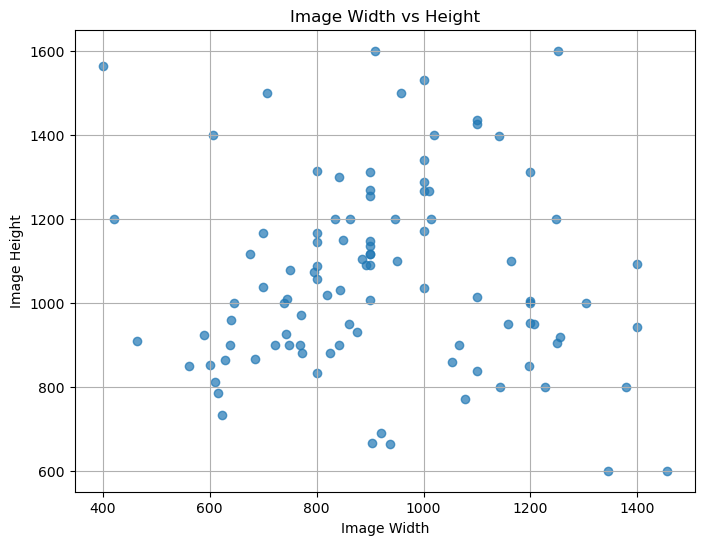

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(img_validation_df['img_width'], img_validation_df['img_height'], alpha=0.7)
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Image Width vs Height')
plt.grid(True)
plt.show()

### Histogram

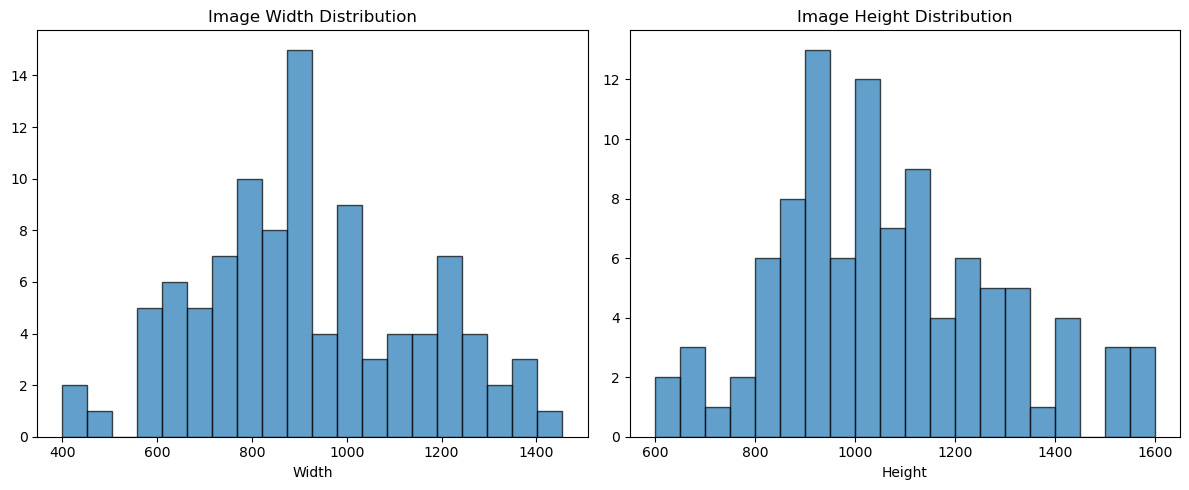

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(img_validation_df['img_width'], bins=20, alpha=0.7, edgecolor='black', linewidth=1)
axs[0].set_title('Image Width Distribution')
axs[0].set_xlabel('Width')

axs[1].hist(img_validation_df['img_height'], bins=20, alpha=0.7, edgecolor='black', linewidth=1)
axs[1].set_title('Image Height Distribution')
axs[1].set_xlabel('Height')

plt.tight_layout()
plt.show()

The histogram shows a variety in image widths and heights, this needs to be normalised before usage

## Visualization

### Bar plots

For the categories a bar plot will be defined

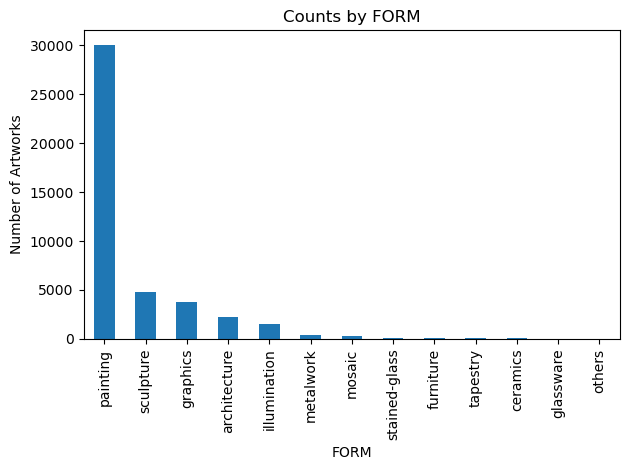

In [24]:
plt.figure()
df['FORM'].value_counts().plot.bar()
plt.title('Counts by FORM')
plt.ylabel('Number of Artworks')
plt.tight_layout()

There are overall more paintings then any other type of art, this could be a good indication to only use paintings from now to keep the modelling simpler. There will likely be more correlated information with the FORM paintings

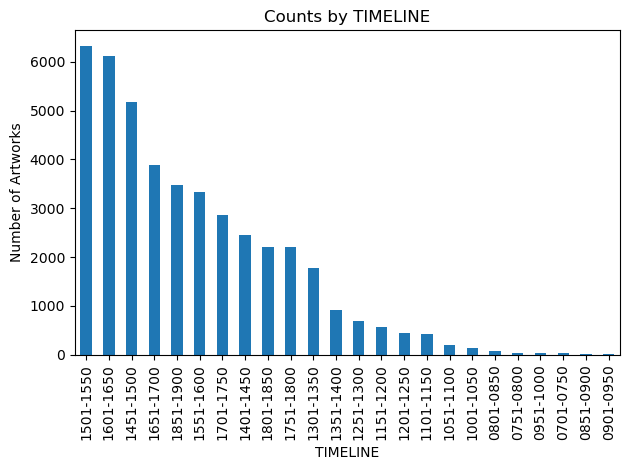

In [25]:
plt.figure()
df['TIMELINE'].value_counts().plot.bar()
plt.title('Counts by TIMELINE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

Most artworks are between the years 1451 and 1700

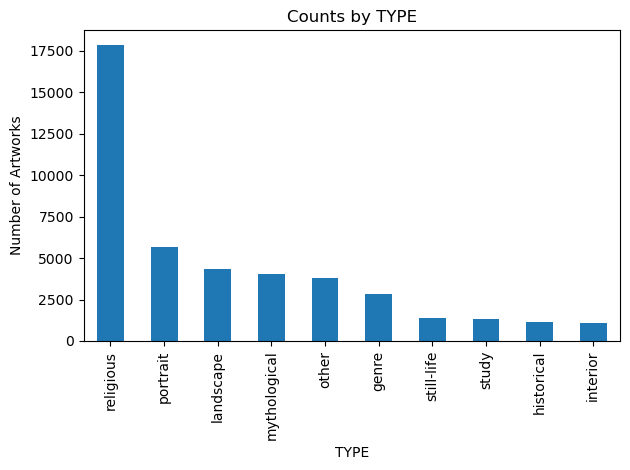

In [26]:
plt.figure()
df['TYPE'].value_counts().plot.bar()
plt.title('Counts by TYPE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

Most of the artwork fall under the type `religious` with `portrait`, `landscape` and `mythological` also numbering high

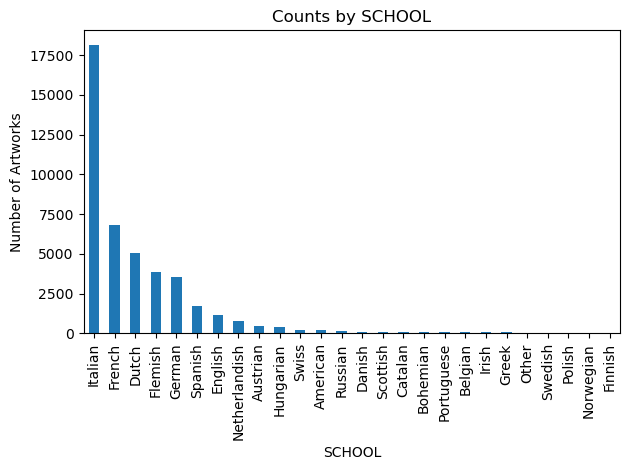

In [27]:
plt.figure()
df['SCHOOL'].value_counts().plot.bar()
plt.title('Counts by SCHOOL')
plt.ylabel('Number of Artworks')
plt.tight_layout()

Most artwork are produced by artist that went to a Italian, French or Dutch school

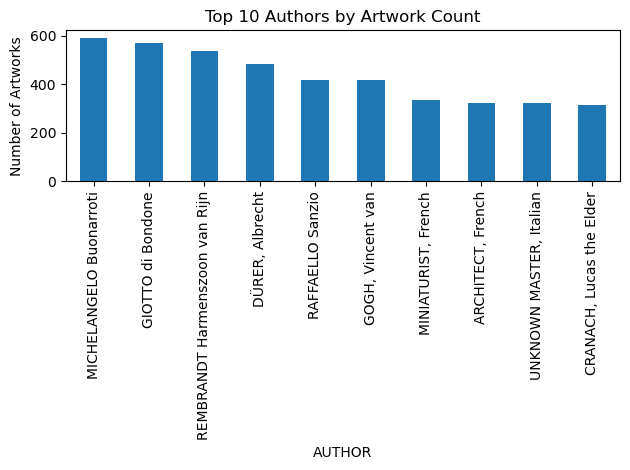

In [28]:
plt.figure()
df['AUTHOR'].value_counts().head(10).plot.bar()
plt.title('Top 10 Authors by Artwork Count')
plt.ylabel('Number of Artworks')
plt.tight_layout()

Based on this information the data will be reduced to only include artworks ot the style `painting`

In [29]:
df = df[df['FORM'] == 'painting']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30003 entries, 0 to 43445
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          30003 non-null  int64   
 1   FILE        30003 non-null  object  
 2   AUTHOR      30003 non-null  object  
 3   TITLE       30003 non-null  object  
 4   DATE        30003 non-null  object  
 5   LOCATION    30003 non-null  category
 6   FORM        30003 non-null  category
 7   TYPE        30003 non-null  category
 8   SCHOOL      30003 non-null  category
 9   TIMELINE    30003 non-null  category
 10  URL         30003 non-null  object  
 11  IMAGE_PATH  30003 non-null  object  
dtypes: category(5), int64(1), object(6)
memory usage: 2.2+ MB


In [ ]:
profile = ProfileReport(df, title="EDA Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00,  9.35it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

As can be seen in the report the data is quite clean, only the `location` has a valid alert of a high cardinality.
The most interesting section in the report is the correlation between the categories. It can be seen that there is a low correlation between the `timeline` and the `type`. It is repeated that the most common values are religious, portrait, landscape and mythological. It is good to spend more time on the correlation between the visuals and the labels. For this the dataset will be decreased in size to 500 samples per type

In [31]:
TYPES_TO_KEEP = ['religious', 'portrait', 'landscape', 'mythological']
SAMPLES_PER_TYPE = 500

df['TYPE'] = df['TYPE'].str.strip().str.lower()
TYPES_TO_KEEP = [t.lower() for t in TYPES_TO_KEEP]

filtered_df = (
    df[df['TYPE'].isin(TYPES_TO_KEEP)]
    .groupby('TYPE', group_keys=False)
    .apply(lambda x: x.sample(n=SAMPLES_PER_TYPE, random_state=SEED))
    .reset_index(drop=True)
)
print(filtered_df['TYPE'].value_counts())

TYPE
landscape       500
mythological    500
portrait        500
religious       500
Name: count, dtype: int64


C:\Users\laure\AppData\Local\Temp\ipykernel_28524\3359108490.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=SAMPLES_PER_TYPE, random_state=SEED))


## Correlation
In the previous iteration dimensionality reduction via PCA was performed to find any correclation between image visuals and the TYPE, UMAP was also tried. This did not result in clear islands.
Now the images will be transformed by using resnet50, these will then be converted to a matrix and visualized with umap

In [42]:
# Load pretrained ResNet50 model (remove classification head)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Image preprocessing for ResNet50
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

# Feature extraction function
def extract_features_pytorch(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_t).squeeze().numpy()
    return features  # 2048-dim

# Apply to your dataframe
filtered_df['img_features'] = filtered_df['IMAGE_PATH'].apply(extract_features_pytorch)

c:\Users\laure\anaconda3\envs\art_assistant_eda_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\laure\anaconda3\envs\art_assistant_eda_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
X = np.stack(filtered_df['img_features'].values)
y = filtered_df['TYPE'].values

c:\Users\laure\anaconda3\envs\art_assistant_eda_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\laure\AppData\Local\Temp\ipykernel_28524\1109588808.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(type_labels))


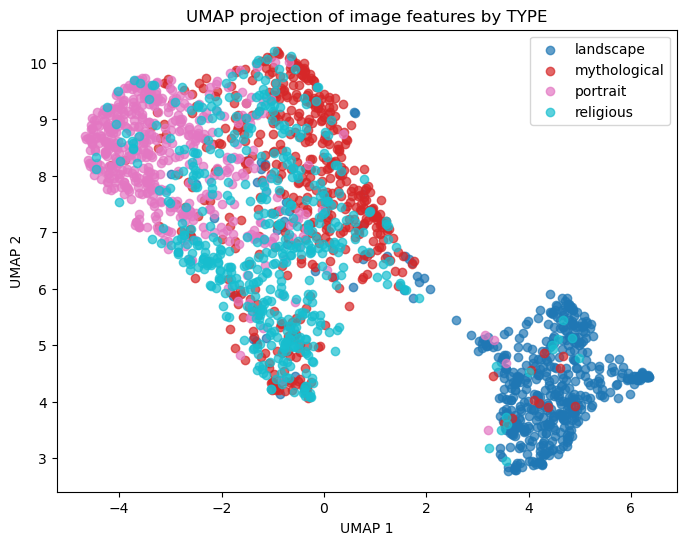

In [53]:
import umap

umap_model = umap.UMAP()
X_umap_img_only = umap_model.fit_transform(X)

type_labels = np.unique(y)
cmap = plt.cm.get_cmap('tab10', len(type_labels))
type2color = {t: cmap(i) for i, t in enumerate(type_labels)}

plt.figure(figsize=(8,6))
for t in np.unique(y):
    mask = (y == t)
    plt.scatter(X_umap_img_only[mask, 0], X_umap_img_only[mask, 1], label=t, alpha=0.7, color=type2color[t])
plt.legend()
plt.title("UMAP projection of image features by TYPE")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

The resnet50 model does work better than the methods used in the previous iteration to extract visual information.

For landscape there is a clear cluster separation on the right, a model should find this easiest to separate Portrait, religious and mythological images largely overlap but each shows some tendency to cluster. Even though there is a tendency to create visually distinct clusters there is too much overlap and noice. The interpreation of this could be that some portrait paintings may be visually similar to religious ones (religious portraits), and mythological paintings might be visually the same as either. The resnet model onle seems to understand the landscape visual features well as these might be diffferent enough to the other types.

Finding the difference between portrait, mythological, and religious will be harder using only standard image features. Adding metadata or fine-tuning a model might be benificial for the overall accuracy.

In a previous iteration it was mentioned that timeline could help the model understand the art better, since there is also a slight correlation between type and timeline this will be plotted into umap

c:\Users\laure\anaconda3\envs\art_assistant_eda_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\laure\anaconda3\envs\art_assistant_eda_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


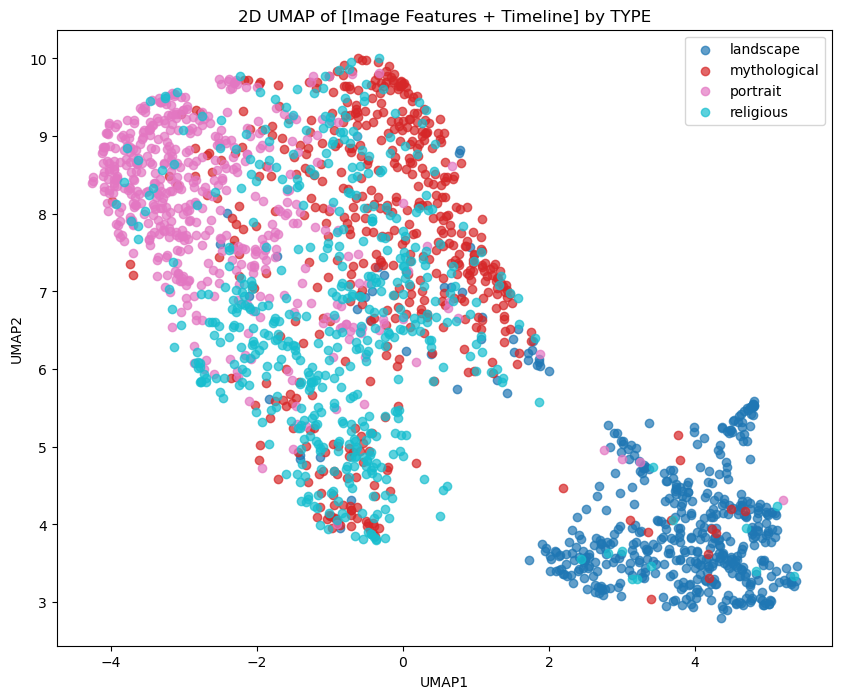

In [ ]:
X_img = np.stack(filtered_df['img_features'].values)  # shape: (n_samples, 2048)

# One-hot encode TIMELINE
timeline_onehotenc = OneHotEncoder(sparse_output=False)
X_timeline = timeline_onehotenc.fit_transform(filtered_df[['TIMELINE']])  # shape: (n_samples, n_periods)

# Concatenate image features + timeline encoding
X_combined = np.concatenate([X_img, X_timeline], axis=1)
umap = umap.UMAP(n_components=2, random_state=42)
X_umap_img_time = umap.fit_transform(X_combined)

plt.figure(figsize=(10, 8))
for t in type_labels:
    mask = (y == t)
    plt.scatter(X_umap_img_time[mask, 0], X_umap_img_time[mask, 1], label=t, alpha=0.7, color=type2color[t])
plt.title('2D UMAP of [Image Features + Timeline] by TYPE')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()


While adding timeline metadata does result in a small improvement in class separation and prediction performance, this effect is not substantial enough to warrant requiring users to provide additional metadata. For real-world, user-facing deployment, an image-only classifier remains the most practical solution.

**SUNBURST does not render?**

In [ ]:
# import plotly.express as px

# top_locations = df['LOCATION'].value_counts().nlargest(2).index
# top_types = df['TYPE'].value_counts().nlargest(3).index
# top_timelines = df['TIMELINE'].value_counts().nlargest(3).index

# filtered_df = df[
#     df['LOCATION'].isin(top_locations) &
#     df['TYPE'].isin(top_types) &
#     df['TIMELINE'].isin(top_timelines)
# ]

# agg_df = (
#     filtered_df
#     .groupby(['LOCATION', 'TYPE', 'TIMELINE'], observed=True)
#     .size()
#     .reset_index(name='COUNT')
# )

# print("Agg_df", agg_df.shape)
# print("filter_df shape", filtered_df.shape)

In [ ]:
# fig = px.sunburst(
#     agg_df,
#     path=['LOCATION', 'TYPE', 'TIMELINE'],
#     values='COUNT',
#     title='Artworks by Location, Type, and Timeline (Top 3 of Each)',
#     width=1200, height=800
# )

# # fig.show()
# fig.write_html("sunburst.html", include_plotlyjs='inline', full_html=True)

In [ ]:
# df.sample(n=10)

# Ideas for plotting

In [ ]:
# Grid where columns are the art form with example below the header
# Sankey diagram starting with the school to type and then form

To speed up the first iteration all other visualizations will be done in a future iteration.

# Conclusion

While the ART500K Toy Dataset provides a broad selection of artworks with categorical metadata for type, form, timeperiod, etc, it lacks explicit labels for fine grained art movements or curated collections. This makes direct modeling or analysis of movement level curation not feasible. Although the TIMELINE field could be used as a loose placeholder, this would introduce additional noise and does not substitute for explicit movement annotation.

Without a ground truth for collections, the fit check phase in this iteration could use synthetic groupings based on available metadata (type, period). The results will show technical feasibility for such groupings but is unlikely to capture the complexity of real curatorial practice. Outcomes from this prototype will be reviewed and lessons learned will inform if project objectives should be refined or rescoped in following iterations. THe downside of this is that an end user then also needs to upload a timeperiod with the image unless a hybrid approach is to be chosen.

*Key EDA outcomes:*
- Absence of explicit movement or style labels.
- All label records are now reliably linked to existing image files, with irrelevant or ambiguous fields removed.
- Focusing on paintings (FORM) and four types with enough data availability (TYPE: religious, portrait, landscape, mythological) provides a relevant subset for the initial modeling phase.
- Normalization of categorical variables and removal of problematic columns reduces risk of mislabeling and improves data quality.
- Clustering the visual features by TYPE using UMAP revealed that the "landscape" category forms a distinct and well-separated cluster, while portrait, religious, and mythological types show substantial overlap.
- Incorporating TIMELINE metadata into the feature set resulted in only marginal improvement in cluster separation. The improvement is not substantial enough to justify the additional complexity or the requirement for users to supply timeline information at prediction time.
- Exploratory Data Analysis using ydata-profiling provided a comprehensive overview of the dataset, helping to quickly identify missing data, distributions, and potential correlations between features.


*Remaining challenges:*
- Variation in image sizes must be addressed in image preprocessing.
- Several metadata fields remain inconsistently formatted or unprocessed, and may require further cleaning or enrichment for future iterations.

*Feasibility:*
Despite these constraints the dataset supports meaningful prototyping of fit-checks and basic grouping based on the selected metadata fields. Insights from this cycle will directly inform the direction and scope of future iterations.